In [33]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [34]:
reviews = pd.read_csv(
    "../dataset/ratings.csv",
    names=["UserID", "MovieID", "Rating", "Timestamp"]
).drop(columns=["Timestamp"])

movies = pd.read_csv(
    "../dataset/movies.csv",
    encoding="latin1",
    names=["MovieID", "Title", "Genre"]
)

reviews

,UserID,MovieID,Rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [35]:
movies

,MovieID,Title,Genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [36]:
movie_review_df = pd.merge(reviews,movies, on="MovieID")
movie_review_df.head()

,UserID,MovieID,Rating,Title,Genre
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [37]:
ratings_matrix = movie_review_df.pivot_table(
    index="MovieID",
    columns="UserID",
    values="Rating"
)

movie_review_matrix = ratings_matrix.apply(lambda row: row.fillna(row.mean()), axis = 1)

In [ ]:
pca = PCA(n_components=50)
ratings_pca = pca.fit_transform(movie_review_matrix)

# Fit KNN model on PCA-reduced data
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(ratings_pca)

# Map movie IDs to titles for lookup
movie_id_to_title = movies.set_index('MovieID')['Title'].to_dict()

input_title = "Star Wars: Episode IV - A New Hope (1977)"  # Example input title

In [ ]:
endList = []
input_movie = movies[movies['Title'] == input_title]
input_id = input_movie['MovieID'].values[0]

movie_idx = movie_review_matrix.index.get_loc(input_id)
_, indices = model_knn.kneighbors(
    ratings_pca[movie_idx].reshape(1, -1), n_neighbors=6
)

for i in range(1, 6):  # skip the first (itself)
    similar_idx = movie_review_matrix.index[indices[0][i]]
    endList.append(movie_id_to_title[similar_idx])

print (endList)

['The Lego Batman Movie (2017)', 'Adventures of Tintin, The (2011)', 'No Country for Old Men (2007)', "Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's Tale) (2009)", 'Last King of Scotland, The (2006)']


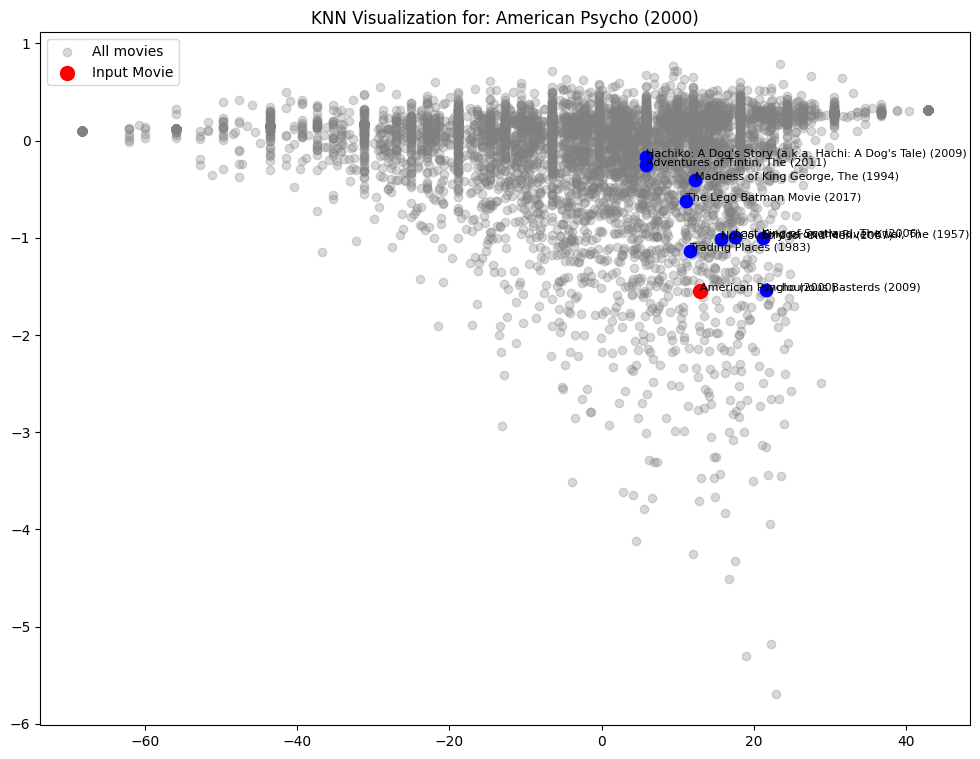

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# -------------------------------------
# Assume you already have the following:
# movie_review_matrix: DataFrame with MovieID as index, rows as users
# movies: DataFrame with 'MovieID' and 'Title' columns
# -------------------------------------

# 1. Apply PCA to reduce dimensionality
pca = PCA(n_components=50)
ratings_pca = pca.fit_transform(movie_review_matrix)

# 2. Fit KNN model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(ratings_pca)

# 3. Map MovieID to Title
movie_id_to_title = movies.set_index('MovieID')['Title'].to_dict()

# 4. Input movie title
input_title = "Star Wars: Episode IV - A New Hope (1977)"

# 5. Find MovieID and index in the matrix
input_movie_id = movies[movies['Title'] == input_title]['MovieID'].values[0]
input_index = movie_review_matrix.index.get_loc(input_movie_id)

# 6. Get neighbors
distances, indices = model_knn.kneighbors([ratings_pca[input_index]], n_neighbors=10)

# 7. Reduce to 2D for plotting
pca_2d = PCA(n_components=2)
ratings_2d = pca_2d.fit_transform(ratings_pca)

# 8. Plotting
plt.figure(figsize=(12, 9))
plt.scatter(ratings_2d[:, 0], ratings_2d[:, 1], alpha=0.3, label='All movies', color='gray')

# Highlight the input movie
plt.scatter(ratings_2d[input_index, 0], ratings_2d[input_index, 1], color='red', s=100, label='Input Movie')

# Highlight neighbors
for i in indices[0]:
    if i != input_index:
        plt.scatter(ratings_2d[i, 0], ratings_2d[i, 1], color='blue', s=80)

# Annotate neighbors (including input)
for i in indices[0]:
    title = movie_id_to_title.get(movie_review_matrix.index[i], "Unknown")
    plt.annotate(title, (ratings_2d[i, 0], ratings_2d[i, 1]), fontsize=8)

plt.title(f"KNN Visualization for: {input_title}")
plt.legend()
